### Setup ###

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
stores_df = pd.read_csv('data/stores.csv')
oil_df = pd.read_csv('data/oil.csv')
holidays_events_df = pd.read_csv('data/holidays_events.csv')
transactions_df = pd.read_csv('data/transactions.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')


In [19]:
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])
oil_df['date'] = pd.to_datetime(oil_df['date'])

In [20]:
for df in [train_df, test_df]:
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['weekday'] = df['date'].dt.weekday

### Data Exploration ###

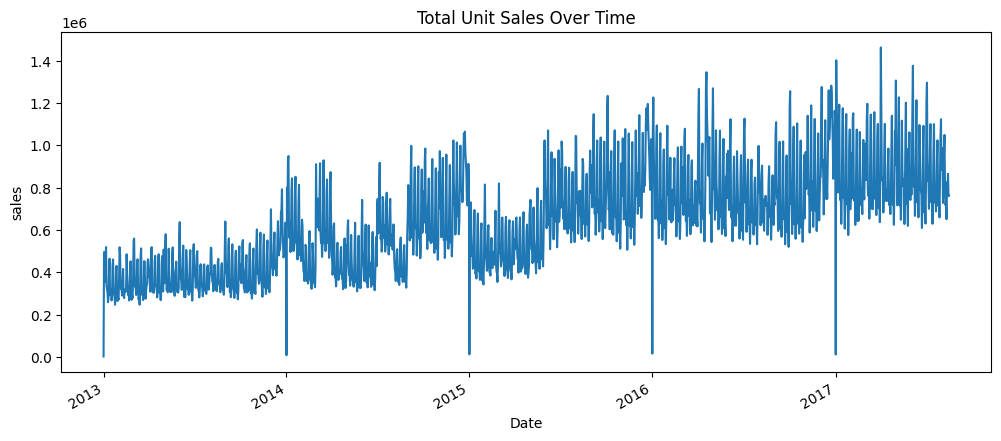

In [21]:
sales_over_time = train_df.groupby('date')['sales'].sum()
plt.figure(figsize=(12,5))
sales_over_time.plot()
plt.title("Total Unit Sales Over Time")
plt.xlabel("Date")
plt.ylabel("sales")
plt.show()

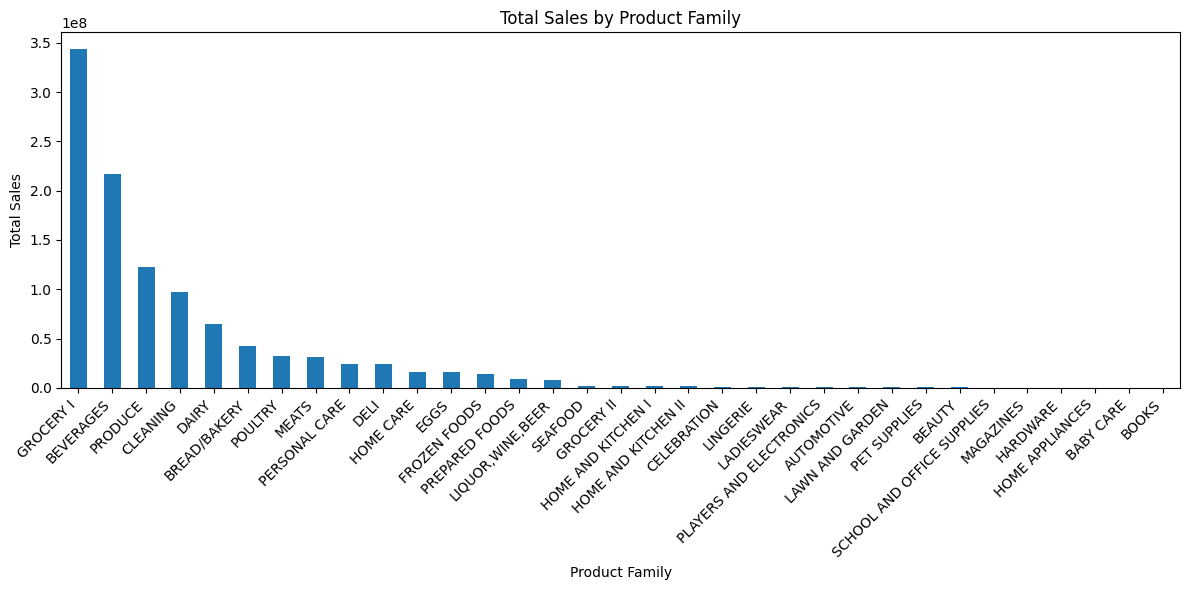

In [22]:
# Create sales_by_family variable first
sales_by_family = train_df.groupby('family')['sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sales_by_family.plot(kind='bar')
plt.title("Total Sales by Product Family")
plt.xlabel("Product Family")
plt.ylabel("Total Sales")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

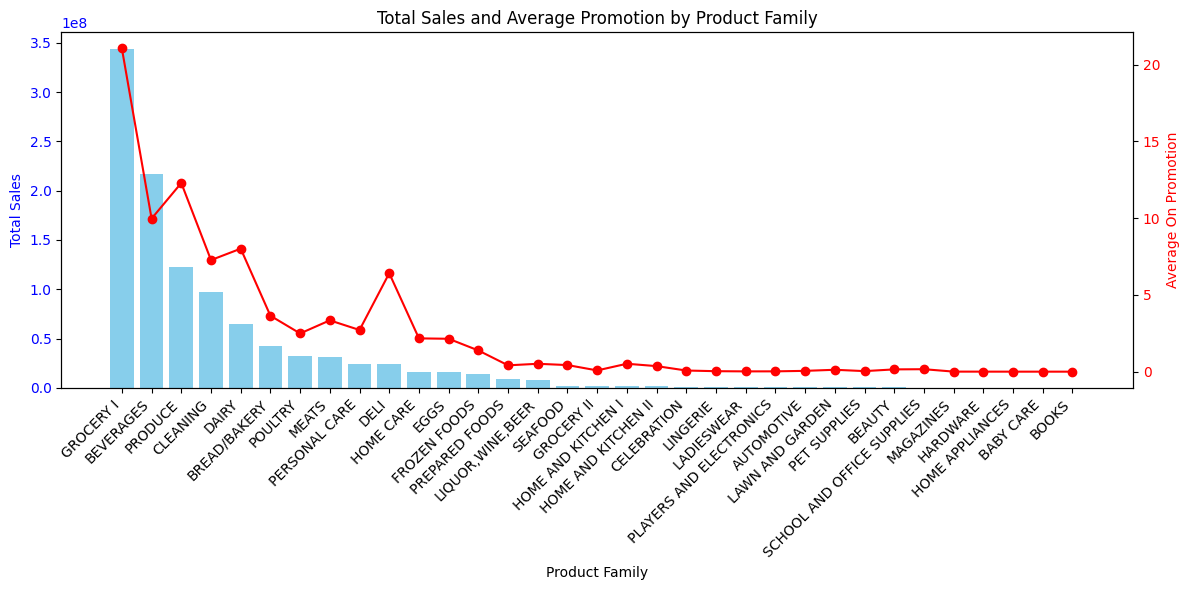

In [23]:
agg_data = train_df.groupby('family').agg({
    'sales': 'sum',
    'onpromotion': 'mean'
}).sort_values('sales', ascending=False)
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.bar(agg_data.index, agg_data['sales'], color='skyblue', label='Total Sales')
ax1.set_xlabel('Product Family')
ax1.set_ylabel('Total Sales', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(range(len(agg_data.index)))
ax1.set_xticklabels(agg_data.index, rotation=45, ha='right')
ax2 = ax1.twinx()
ax2.plot(agg_data.index, agg_data['onpromotion'], color='red', marker='o', label='Average Promotion')
ax2.set_ylabel('Average On Promotion', color='red')
ax2.tick_params(axis='y', labelcolor='red')
plt.title('Total Sales and Average Promotion by Product Family')
fig.tight_layout()
plt.show()

In [24]:
train_df['date'] = pd.to_datetime(train_df['date'])
train_df = pd.merge(train_df, oil_df, on='date', how='left')

In [25]:
daily_sales = train_df.groupby('date')['sales'].sum().reset_index()
daily_sales = pd.merge(daily_sales, oil_df, on='date', how='left')


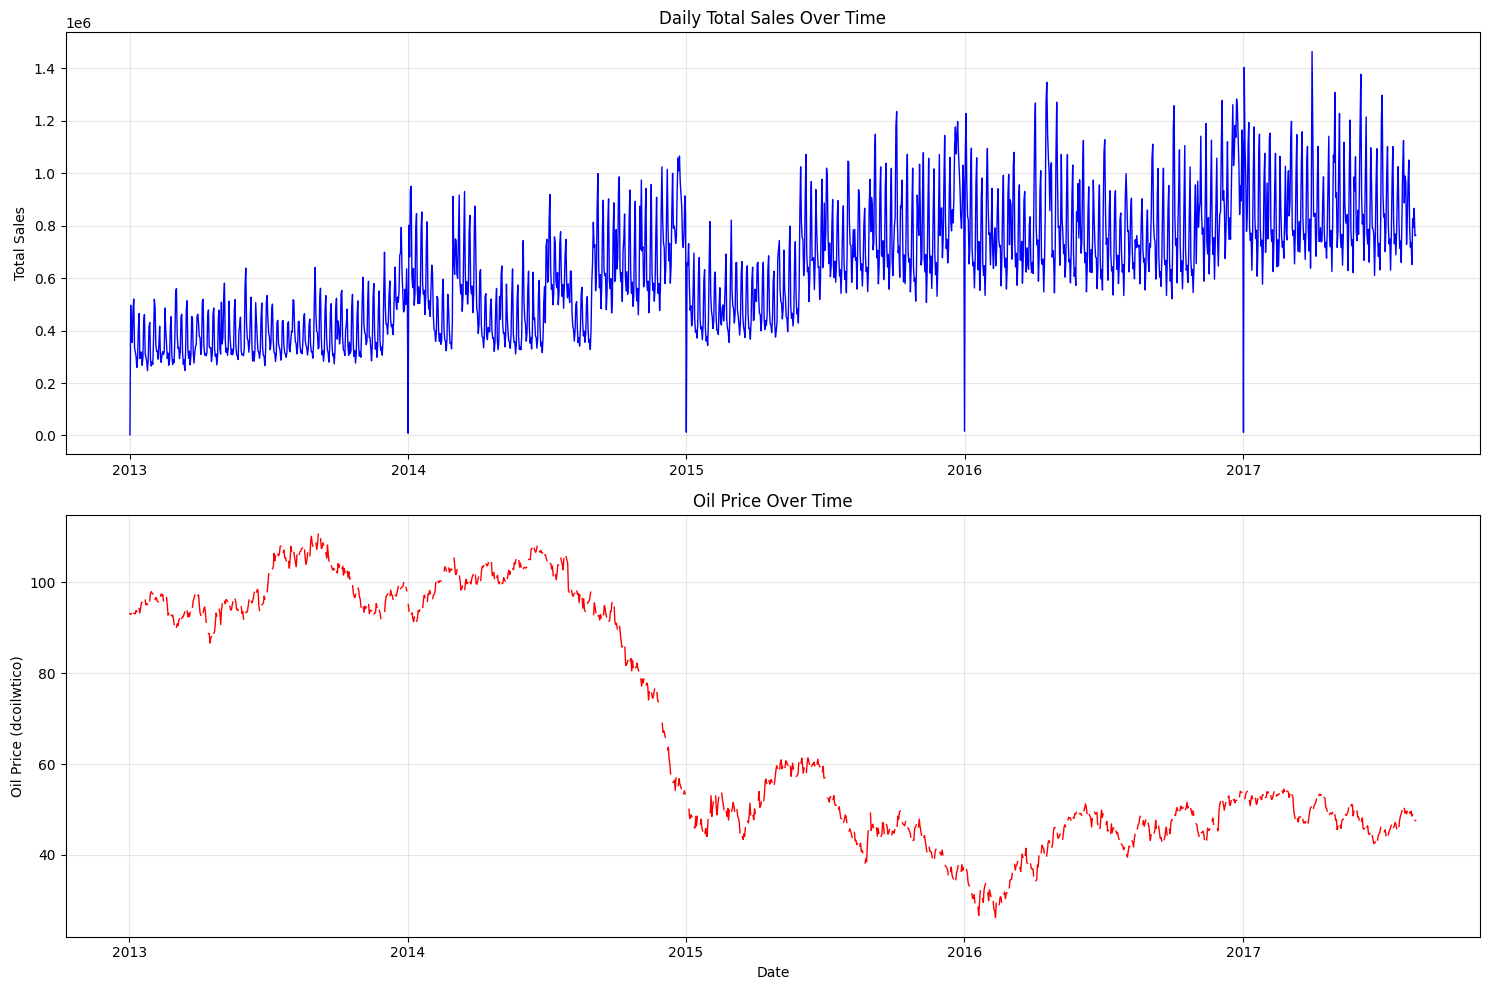

In [26]:

# Alternative: Time series plot showing both sales and oil price over time
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Daily sales over time
daily_sales = train_df.groupby('date')['sales'].sum().reset_index()
ax1.plot(daily_sales['date'], daily_sales['sales'], color='blue', linewidth=1)
ax1.set_title('Daily Total Sales Over Time')
ax1.set_ylabel('Total Sales')
ax1.grid(True, alpha=0.3)

# Plot 2: Oil price over time
daily_oil = train_df.groupby('date')['dcoilwtico'].mean().reset_index()
ax2.plot(daily_oil['date'], daily_oil['dcoilwtico'], color='red', linewidth=1)
ax2.set_title('Oil Price Over Time')
ax2.set_xlabel('Date')
ax2.set_ylabel('Oil Price (dcoilwtico)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()




### Feature Engineering ###

In [27]:
# Create comprehensive time-based features
print("Creating time-based features...")

# Ensure date column is datetime
train_df['date'] = pd.to_datetime(train_df['date'])

# 1. Basic time components
train_df['day_of_week'] = train_df['date'].dt.dayofweek  # Monday=0, Sunday=6
train_df['day_of_month'] = train_df['date'].dt.day
train_df['month'] = train_df['date'].dt.month
train_df['quarter'] = train_df['date'].dt.quarter
train_df['year'] = train_df['date'].dt.year
train_df['week_of_year'] = train_df['date'].dt.isocalendar().week

# 2. Derived time features
train_df['is_weekend'] = (train_df['day_of_week'] >= 5).astype(int)  # Saturday=5, Sunday=6
train_df['is_month_start'] = (train_df['day_of_month'] <= 3).astype(int)  # First 3 days
train_df['is_month_end'] = (train_df['day_of_month'] >= 28).astype(int)  # Last 3 days
train_df['is_quarter_start'] = train_df['date'].dt.is_quarter_start.astype(int)
train_df['is_quarter_end'] = train_df['date'].dt.is_quarter_end.astype(int)

# 3. Cyclical encoding for better model performance
train_df['day_of_week_sin'] = np.sin(2 * np.pi * train_df['day_of_week'] / 7)
train_df['day_of_week_cos'] = np.cos(2 * np.pi * train_df['day_of_week'] / 7)
train_df['month_sin'] = np.sin(2 * np.pi * train_df['month'] / 12)
train_df['month_cos'] = np.cos(2 * np.pi * train_df['month'] / 12)

# 4. Holiday-related features
# First, let's prepare holiday data
holidays_events_df['date'] = pd.to_datetime(holidays_events_df['date'])
holidays_events_df['is_holiday'] = 1

# Merge holiday information
train_df = train_df.merge(
    holidays_events_df[['date', 'is_holiday', 'type']], 
    on='date', 
    how='left'
)
train_df['is_holiday'] = train_df['is_holiday'].fillna(0).astype(int)

# Create holiday type features
holiday_types = holidays_events_df['type'].unique()
for holiday_type in holiday_types:
    train_df[f'is_{holiday_type.lower().replace(" ", "_")}'] = 0
    mask = holidays_events_df['type'] == holiday_type
    holiday_dates = holidays_events_df.loc[mask, 'date']
    train_df.loc[train_df['date'].isin(holiday_dates), f'is_{holiday_type.lower().replace(" ", "_")}'] = 1

print("✅ Time-based features created successfully!")
print(f"New features added: {[col for col in train_df.columns if col not in ['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'dcoilwtico']]}")


Creating time-based features...
✅ Time-based features created successfully!
New features added: ['day', 'month', 'year', 'weekday', 'day_of_week', 'day_of_month', 'quarter', 'week_of_year', 'is_weekend', 'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'is_holiday', 'type', 'is_transfer', 'is_additional', 'is_bridge', 'is_work_day', 'is_event']


In [28]:
# Create lagged features and rolling averages
print("Creating lagged features and rolling averages...")

# Sort data by store, family, and date for proper lag calculation
train_df = train_df.sort_values(['store_nbr', 'family', 'date']).reset_index(drop=True)

# 5. Lagged sales features (for each store-family combination)
train_df['sales_lag_1'] = train_df.groupby(['store_nbr', 'family'])['sales'].shift(1)
train_df['sales_lag_7'] = train_df.groupby(['store_nbr', 'family'])['sales'].shift(7)
train_df['sales_lag_14'] = train_df.groupby(['store_nbr', 'family'])['sales'].shift(14)
train_df['sales_lag_30'] = train_df.groupby(['store_nbr', 'family'])['sales'].shift(30)

# 6. Rolling averages
train_df['sales_ma_7'] = train_df.groupby(['store_nbr', 'family'])['sales'].rolling(window=7).mean().reset_index(0, drop=True)
train_df['sales_ma_14'] = train_df.groupby(['store_nbr', 'family'])['sales'].rolling(window=14).mean().reset_index(0, drop=True)
train_df['sales_ma_30'] = train_df.groupby(['store_nbr', 'family'])['sales'].rolling(window=30).mean().reset_index(0, drop=True)

# 7. Rolling standard deviations (volatility)
train_df['sales_std_7'] = train_df.groupby(['store_nbr', 'family'])['sales'].rolling(window=7).std().reset_index(0, drop=True)
train_df['sales_std_30'] = train_df.groupby(['store_nbr', 'family'])['sales'].rolling(window=30).std().reset_index(0, drop=True)

# 8. Rolling maximum and minimum
train_df['sales_max_7'] = train_df.groupby(['store_nbr', 'family'])['sales'].rolling(window=7).max().reset_index(0, drop=True)
train_df['sales_min_7'] = train_df.groupby(['store_nbr', 'family'])['sales'].rolling(window=7).min().reset_index(0, drop=True)

# 9. Oil price features
train_df['oil_price_lag_1'] = train_df['dcoilwtico'].shift(1)
train_df['oil_price_ma_7'] = train_df['dcoilwtico'].rolling(window=7).mean()
train_df['oil_price_ma_30'] = train_df['dcoilwtico'].rolling(window=30).mean()
train_df['oil_price_change'] = train_df['dcoilwtico'].pct_change()

# 10. Promotion features
train_df['promotion_lag_1'] = train_df.groupby(['store_nbr', 'family'])['onpromotion'].shift(1)
train_df['promotion_ma_7'] = train_df.groupby(['store_nbr', 'family'])['onpromotion'].rolling(window=7).mean().reset_index(0, drop=True)

print("✅ Lagged features and rolling averages created successfully!")
print(f"Total features now: {len(train_df.columns)}")
print(f"Sample of new features: {[col for col in train_df.columns if 'lag' in col or 'ma' in col or 'std' in col][:10]}")


Creating lagged features and rolling averages...


TypeError: incompatible index of inserted column with frame index

In [32]:
# Feature summary and basic statistics
print("📊 FEATURE SUMMARY")
print("=" * 50)

# Show all features
all_features = train_df.columns.tolist()
print(f"Total features: {len(all_features)}")
print(f"All features: {all_features}")

# Categorize features
time_features = [col for col in all_features if any(x in col for x in ['day', 'month', 'quarter', 'year', 'week', 'weekend', 'start', 'end', 'sin', 'cos'])]
lag_features = [col for col in all_features if 'lag' in col]
ma_features = [col for col in all_features if 'ma' in col]
std_features = [col for col in all_features if 'std' in col]
holiday_features = [col for col in all_features if 'holiday' in col or 'is_' in col]
oil_features = [col for col in all_features if 'oil' in col]
promotion_features = [col for col in all_features if 'promotion' in col]

print(f"\n📅 Time features ({len(time_features)}): {time_features}")
print(f"⏰ Lag features ({len(lag_features)}): {lag_features}")
print(f"📈 Moving average features ({len(ma_features)}): {ma_features}")
print(f"📊 Standard deviation features ({len(std_features)}): {std_features}")
print(f"🎉 Holiday features ({len(holiday_features)}): {holiday_features}")
print(f"🛢️ Oil price features ({len(oil_features)}): {oil_features}")
print(f"🏷️ Promotion features ({len(promotion_features)}): {promotion_features}")

# Show basic statistics for key features
print(f"\n📋 BASIC STATISTICS")
print("=" * 30)
print(f"Dataset shape: {train_df.shape}")
print(f"Date range: {train_df['date'].min()} to {train_df['date'].max()}")
print(f"Number of stores: {train_df['store_nbr'].nunique()}")
print(f"Number of product families: {train_df['family'].nunique()}")
print(f"Missing values in key features:")
print(f"  - sales_lag_1: {train_df['sales_lag_1'].isna().sum()}")
print(f"  - sales_ma_28: {train_df['sales_ma_28'].isna().sum()}")
print(f"  - oil_price_ma_7: {train_df['oil_price_ma_7'].isna().sum()}")

# Show sample of the enhanced dataset
print(f"\n🔍 SAMPLE OF ENHANCED DATASET")
print("=" * 40)
print(train_df[['date', 'store_nbr', 'family', 'sales', 'day_of_week', 'is_weekend', 'sales_lag_1', 'sales_ma_7', 'is_holiday']].head(10))


📊 FEATURE SUMMARY
Total features: 35
All features: ['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'day', 'month', 'year', 'weekday', 'dcoilwtico', 'day_of_week', 'day_of_month', 'quarter', 'week_of_year', 'is_weekend', 'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'is_holiday', 'type', 'is_transfer', 'is_additional', 'is_bridge', 'is_work_day', 'is_event', 'sales_lag_1', 'sales_lag_7', 'sales_lag_14', 'sales_lag_30']

📅 Time features (19): ['day', 'month', 'year', 'weekday', 'day_of_week', 'day_of_month', 'quarter', 'week_of_year', 'is_weekend', 'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'is_holiday', 'is_work_day']
⏰ Lag features (4): ['sales_lag_1', 'sales_lag_7', 'sales_lag_14', 'sales_lag_30']
📈 Moving average features (0): []
📊 Standard deviation features (0): []
🎉 Holiday features (11)

KeyError: 'sales_ma_28'

### Model Training ###

In [ ]:

# Calculate moving averages for each store-family combination
def generate_ma_predictions(df, val_df, window=28):
    """Calculate moving averages for each store-family combination"""
    df = df.sort_values(['store_nbr', 'family', 'date']).reset_index(drop=True)
    df = pd.concat([df, val_df]).reset_index(drop=True)
    df[f'ma_{window}'] = df.groupby(['store_nbr', 'family'])['sales'].transform(
        lambda x: x.rolling(window, 1).mean()
    )
    return df


In [40]:
# Forecast horizon
H = 15  

# Last date in training data
last_date = train_df['date'].max()

# Holdout = last 15 days
holdout = train_df[train_df['date'] > last_date - pd.Timedelta(days=H)]
train_fit = train_df[train_df['date'] <= last_date - pd.Timedelta(days=H)]


In [41]:
# Create holdout dates (same as real holdout period)
holdout_dates = holdout['date'].unique()

# All store-family combos
store_families = train_fit[['store_nbr', 'family']].drop_duplicates()

# Build empty rows for predictions
val_benchmark = []
for date in holdout_dates:
    for _, row in store_families.iterrows():
        val_benchmark.append({
            'date': date,
            'store_nbr': row['store_nbr'],
            'family': row['family'],
            'sales': np.nan
        })
val_benchmark = pd.DataFrame(val_benchmark)


In [42]:
preds_df = generate_ma_predictions(train_fit, val_benchmark, window=28)

# Keep only prediction rows
preds_df = preds_df[preds_df['date'].isin(holdout_dates)][
    ['date','store_nbr','family',f'ma_{28}']
].rename(columns={f'ma_{28}':'sales_pred'})


In [43]:
eval_df = holdout.merge(preds_df, on=['date','store_nbr','family'], how='left')
eval_df['sales_pred'] = eval_df['sales_pred'].fillna(0.0)


In [44]:
def rmsle(y_true, y_pred):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    y_pred = np.clip(y_pred, 0, None)  # no negatives
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))

score = rmsle(eval_df['sales'], eval_df['sales_pred'])
print("Validation RMSLE:", score)


Validation RMSLE: 0.5151455759803385


### Competition Submission ###

In [46]:
# Prepare data for the benchmark
train_df_sorted = train_df.sort_values(['store_nbr', 'family', 'date']).reset_index(drop=True)

# Use all available training data
train_benchmark = train_df_sorted.copy()

# Create validation data for the next 15 days after the last training date
last_date = train_benchmark['date'].max()
next_15_days = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=15, freq='D')

# Create validation dataframe with all store-family combinations for next 15 days
store_families = train_benchmark[['store_nbr', 'family']].drop_duplicates()
val_benchmark = []

for date in next_15_days:
    for _, row in store_families.iterrows():
        val_benchmark.append({
            'date': date,
            'store_nbr': row['store_nbr'],
            'family': row['family'],
            'sales': np.nan  # We don't know actual sales for future dates
        })

val_benchmark = pd.DataFrame(val_benchmark)

In [65]:
test_dates = test_df['date'].unique()

# Calculate moving averages on training data
submission_df = generate_ma_predictions(train_benchmark, val_benchmark).reset_index()

# Keep only prediction rows
submission_df = submission_df[submission_df['date'].isin(test_dates)][
    ['date','store_nbr','family',f'ma_{28}']
].rename(columns={f'ma_{28}':'sales_pred'})

In [67]:
submission_df = test_df.merge(submission_df, on=['date','store_nbr','family'], how='left')
submission_df = submission_df[['id', 'sales_pred']].rename(columns={f'sales_pred':'sales'}) 

In [68]:
# Check what you have first
print("Current columns:", submission_df.columns.tolist())

Current columns: ['id', 'sales']


In [ ]:
submission_df['sales'] = submission_df['sales'].fillna(0)
submission_df['sales'] = submission_df['sales'].astype(float)
submission_df.to_csv("submission.csv", index=False)